In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, time, math, csv
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

# Initial setup

In [2]:
shapefile_fn = "data/intermediate/boundary_shapefiles/cb_2015_us_county_500k.shp"
shapefile_key = "GEOID"

# Load data

### Migration data

In [3]:
f = open("data/processed/county_intersection_list_2004_2014.txt")
county_list = f.read().strip().split("\n")
f.close()

county_fips_to_idx = {fips:idx for idx, fips in enumerate(county_list)}
num_counties = len(county_list)

### Per county features

In [4]:
df_medium = pd.read_csv("data/processed/affected_population_medium.csv")
df_high = pd.read_csv("data/processed/affected_population_high.csv")

In [5]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

medium_total_pop = [
    df_medium["Total Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_affected_pop = [
    df_medium["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_unaffected_pop = [
    medium_total_pop[i] - medium_affected_pop[i]
    for i in range(len(medium_years))
]

high_total_pop = [
    df_high["Total Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_affected_pop = [
    df_high["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_unaffected_pop = [
    high_total_pop[i] - high_affected_pop[i]
    for i in range(len(high_years))
]

In [6]:
medium_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in medium_affected_pop
]

high_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in high_affected_pop
]

# DL Results

In [7]:
medium_baseline_migration = [np.load("output/dl_results/dl_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/dl_results/dl_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/dl_results/dl_medium_ablation_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_flooded = [np.load("output/dl_results/dl_medium_affected_results_flooded_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_unflooded = [np.load("output/dl_results/dl_medium_affected_results_unflooded_%d.npy" % (year)) for year in medium_years]


high_baseline_migration = [np.load("output/dl_results/dl_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/dl_results/dl_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/dl_results/dl_high_ablation_results_%d.npy" % (year)) for year in high_years]
high_affected_migration_flooded = [np.load("output/dl_results/dl_high_affected_results_flooded_%d.npy" % (year)) for year in high_years]
high_affected_migration_unflooded = [np.load("output/dl_results/dl_high_affected_results_unflooded_%d.npy" % (year)) for year in high_years]

model = "dl"

# ExtRad Results

In [7]:
medium_baseline_migration = [np.load("output/extrad_results/extrad_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/extrad_results/extrad_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/extrad_results/extrad_medium_ablation_results_%d.npy" % (year)) for year in medium_years]

high_baseline_migration = [np.load("output/extrad_results/extrad_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/extrad_results/extrad_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/extrad_results/extrad_high_ablation_results_%d.npy" % (year)) for year in high_years]

model = "extrad"

# Medium

In [8]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
        if not medium_affected_counties[i][j]
    }
    map_data["46102"] = 0        

    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_both_medium_%d.tiff" % (model, year),
        noDataColor="#0000FFFF",
        cmap="Reds",
        dpi=300,
        size=(7.5,7.5/2.0),
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects, Medium %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

### Affected

In [9]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i][medium_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i][medium_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_affected_medium_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Affected Areas, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0)
    )

### Unnaffected

In [10]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i][~medium_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i][~medium_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_unaffected_medium_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Unaffected Areas, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

### Abalation

In [11]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_ablation_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_ablation_medium_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="ExtRad Ablation, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

# High

In [12]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    count = 0
    for j, county in enumerate(county_list):
        if t_affected_incoming[j] - t_baseline_incoming[j] > 0:
            count += 1
            
    print(year, count / float(len(county_list)))

2042 1.0
2059 1.0
2071 1.0
2082 1.0
2091 0.9996780424983902
2100 0.9996780424983902


In [13]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
        if not high_affected_counties[i][j]
    }
    map_data["46102"] = 0

    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_both_high_%d.tiff" % (model, year),
        noDataColor="#0000FFFF",
        cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

### Affected

In [14]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i][high_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i][high_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_affected_high_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Affected Areas, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

### Unaffected

In [15]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i][~high_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i][~high_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_unaffected_high_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Unaffected Areas, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

### Ablation

In [16]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_ablation_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_ablation_high_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="ExtRad Ablation, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

# Indirect Effect Thresholds

## High

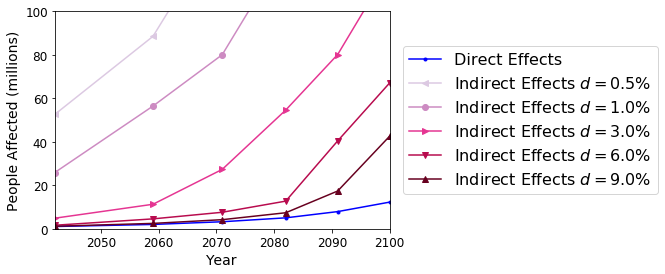

In [17]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
ys_direct = []
ys_thresholds = [[] for threshold in thresholds]
divisor = 1000000.0

for i, year in enumerate(high_years):

    direct_effect = high_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming

    for j, threshold in enumerate(thresholds):
        
        t_pop = high_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))        
        ys_thresholds[j].append(direct_effect + (t_pop[indirect_mask].sum() / divisor))
    
markers = [".", "<", "o", ">", "v", "^", "D"]
cmap = matplotlib.cm.get_cmap("PuRd")
norm = matplotlib.colors.Normalize(vmin=0,vmax=len(thresholds))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

width = 6
plt.figure(figsize=(width, width * (2/3)))

plt.plot(high_years, ys_direct, color="b", marker=markers[0], label="Direct Effects")

for j, threshold in enumerate(thresholds):
    plt.plot(high_years, ys_thresholds[j], color=sm.to_rgba(j+1), marker=markers[j+1], label=r"Indirect Effects $d = %0.1f \%% $" % (threshold))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=16)
plt.subplots_adjust(right=0.9)

plt.xticks(fontsize=12)
plt.xlim([2042,2100])
plt.xlabel("Year", fontsize=14)

plt.yticks(fontsize=12)
plt.ylim([0,100])
plt.ylabel("People Affected (millions)", fontsize=14)

#plt.title("Direct and Indirect Effects on People", fontsize=16)
plt.savefig("output/figures/%s_direct_indirect_high_plot.tiff" % (model), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [18]:
ys_thresholds

[[52.615433514252,
  88.501053472138,
  140.143178184209,
  206.84671046297598,
  275.612801241788,
  372.695697004205],
 [25.8907333842,
  56.441005194218,
  80.05956327319599,
  128.294874825274,
  173.02320991652002,
  249.198184651799],
 [4.878040944301,
  11.281081993387001,
  27.322118504981002,
  54.607691375771005,
  80.151026317234,
  120.04740645611601],
 [1.6361068289300003,
  4.562348919649001,
  7.601259591732001,
  12.72954041689,
  40.424186135252,
  67.075894554874],
 [1.1621265426960001,
  2.4836519266350003,
  4.194823283044,
  7.382391627121999,
  17.376030801037004,
  42.58634106386701]]

In [19]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
labels = [
    "Directly\nAffected"
] + [">%0.1f%%" % (threshold) for threshold in thresholds] + ["Not\nAffected"]

cmap = matplotlib.colors.ListedColormap(
    ["#0000FFFF"] + [sm.to_rgba(j+1) for j in range(len(thresholds))] + ["#FFFFFFFF"],
    N = len(labels)
)
hackMapping = {
    i:i for i in range(len(labels))
}

for i, year in enumerate(high_years):
    
    direct_effect = high_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming
    
    t_map = (high_affected_pop[i] > 0).reshape(-1).astype(int)
    t_mask = (high_affected_pop[i] > 0).reshape(-1)

    for j, threshold in enumerate(thresholds):
        
        t_pop = high_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))
        t_map[indirect_mask] = j+2
    
    t_map[t_map==0] = len(thresholds) + 2
    t_map -= 1
    t_map[t_mask] = 0
    print(np.unique(t_map, return_counts=True))
 
    map_data = {
        county: t_map[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 6

    
    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        cmap=cmap,
        outputFn="output/figures/%s_direct_indirect_high_%d.tiff" % (model, year),
        colorbarType=1,
        colorbarLabels=labels,
        dataToColorIdxMap=hackMapping,
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects at different thresholds, High %d" % (year),
        dpi=300,
        size=(7.5,7.5/2.0),
    )

(array([0, 1, 2, 3, 4, 6]), array([ 336,   19,    8,    3,    1, 2739]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 340,   78,   14,    2,    3,    1, 2668]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 341,  132,   50,    3,    3,    1, 2576]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 345,  221,   92,    4,    3,    2, 2439]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 346,  307,  208,   13,    5,    2, 2225]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 349,  658,  380,   54,    5,    8, 1652]))


## Medium

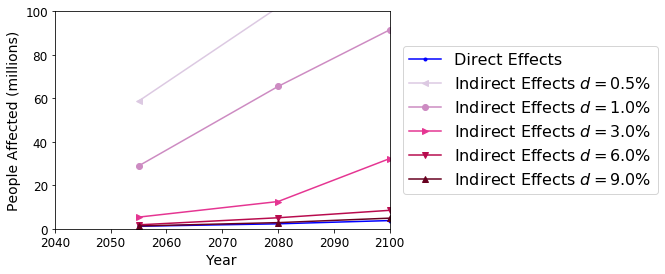

In [20]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
ys_direct = []
ys_thresholds = [[] for threshold in thresholds]
divisor = 1000000.0

for i, year in enumerate(medium_years):

    direct_effect = medium_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming

    for j, threshold in enumerate(thresholds):
        
        t_pop = medium_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))        
        ys_thresholds[j].append(direct_effect + (t_pop[indirect_mask].sum() / divisor))
    
markers = [".", "<", "o", ">", "v", "^", "D"]
cmap = matplotlib.cm.get_cmap("PuRd")
norm = matplotlib.colors.Normalize(vmin=0,vmax=len(thresholds))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
width = 6
plt.figure(figsize=(width, width * (2/3)))

plt.plot(medium_years, ys_direct, color="b", marker=markers[0], label="Direct Effects")

for j, threshold in enumerate(thresholds):
    plt.plot(medium_years, ys_thresholds[j], color=sm.to_rgba(j+1), marker=markers[j+1], label=r"Indirect Effects $d = %0.1f \%% $" % (threshold))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=16)
plt.subplots_adjust(right=0.9)

plt.xticks(fontsize=12)
plt.xlim([2040,2100])
plt.xlabel("Year", fontsize=14)

plt.yticks(fontsize=12)
plt.ylim([0,100])
plt.ylabel("People Affected (millions)", fontsize=14)

#plt.title("Direct and Indirect Effects on People", fontsize=16)
plt.savefig("output/figures/%s_direct_indirect_medium_plot.tiff" % (model), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [21]:
ys_thresholds

[[58.70675646423, 101.85779030117199, 157.456274547938],
 [28.892917546305, 65.46576194264101, 91.476644129654],
 [5.367699949364, 12.533631990512, 32.27763498044],
 [1.8209560921680001, 5.075750492131, 8.495665683812001],
 [1.295178121297, 2.8393323049339996, 4.896351569522]]

In [22]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
labels = [
    "Directly\nAffected"
] + [">%0.1f%%" % (threshold) for threshold in thresholds] + ["Not\nAffected"]

cmap = matplotlib.colors.ListedColormap(
    ["#0000FFFF"] + [sm.to_rgba(j+1) for j in range(len(thresholds))] + ["#FFFFFFFF"],
    N = len(labels)
)
hackMapping = {
    i:i for i in range(len(labels))
}

for i, year in enumerate(medium_years):
    
    direct_effect = medium_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming
    
    t_map = (medium_affected_pop[i] > 0).reshape(-1).astype(int)
    t_mask = (medium_affected_pop[i] > 0).reshape(-1)

    for j, threshold in enumerate(thresholds):
        
        t_pop = medium_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))
        t_map[indirect_mask] = j+2
    
    t_map[t_map==0] = len(thresholds) + 2
    t_map -= 1
    t_map[t_mask] = 0
    print(np.unique(t_map, return_counts=True))
 
    map_data = {
        county: t_map[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 6

    
    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        cmap=cmap,
        outputFn="output/figures/%s_direct_indirect_medium_%d.tiff" % (model, year),
        colorbarType=1,
        colorbarLabels=labels,
        dataToColorIdxMap=hackMapping,
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects at different thresholds, Medium %d" % (year),
        dpi=300,
        size=(7.5,7.5/2.0),
    )

(array([0, 1, 2, 3, 4, 6]), array([ 336,   20,    8,    3,    1, 2738]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 340,   76,   13,    2,    3,    1, 2671]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 341,  125,   44,    3,    3,    1, 2589]))
